# Machine Translation

В этом проекте представлено решение задачи машинного перевода с помощью **encoder-decoder** архитектуры, пробуя различные ее реализации (**RNN/transformer**).

Задача перевода: с русского на английский. Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у нас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

#### Токенизация и кодирование текста
 
С токенезацией хорошо справится `WordPunctTokenizer` из библиотеки `nltk`, а вот с кодированием не все так просто, как может показаться.

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Можно было бы кодировать тексты побуквенно, и это могло бы помочь здесь. Но в таком случае придется очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому предлагается выбрать средний подход этими — [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__ и хорошо зарекомендовавший себя в современных NLP-моделях.

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары — и так $N$ итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE — очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма. Подробный код для токенизации «скрыт» в модуле `vocab.py` — в нем можно посмтреть, как работает этот процесс.

---

In [ ]:
# !pip install subword-nmt, nltk

In [ ]:
# преобразуем и кодируем датасет
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:11<00:00, 671.14it/s] 


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [ ]:
import numpy as np

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
# проверим длину
len(train_inp), len(train_out), len(dev_inp), len(dev_out)

(47001, 47001, 3000, 3000)

In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## EDA — Exploratory Data Analysis

In [ ]:
import random
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from tqdm import tqdm, trange
from typing_extensions import Literal

sns.set(style='darkgrid', palette='deep')
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# узнать, какой GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 12 00:35:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

*Первым делом посмотрим на распределение числа токенов, закодированных с помощью BPE, в предложениях.*

In [ ]:
len_train_inp_by_tok = list(map(len, map(str.split, train_inp)))
len_train_out_by_tok = list(map(len, map(str.split, train_out)))
len_dev_inp_by_tok = list(map(len, map(str.split, dev_inp)))
len_dev_out_by_tok = list(map(len, map(str.split, dev_out)))

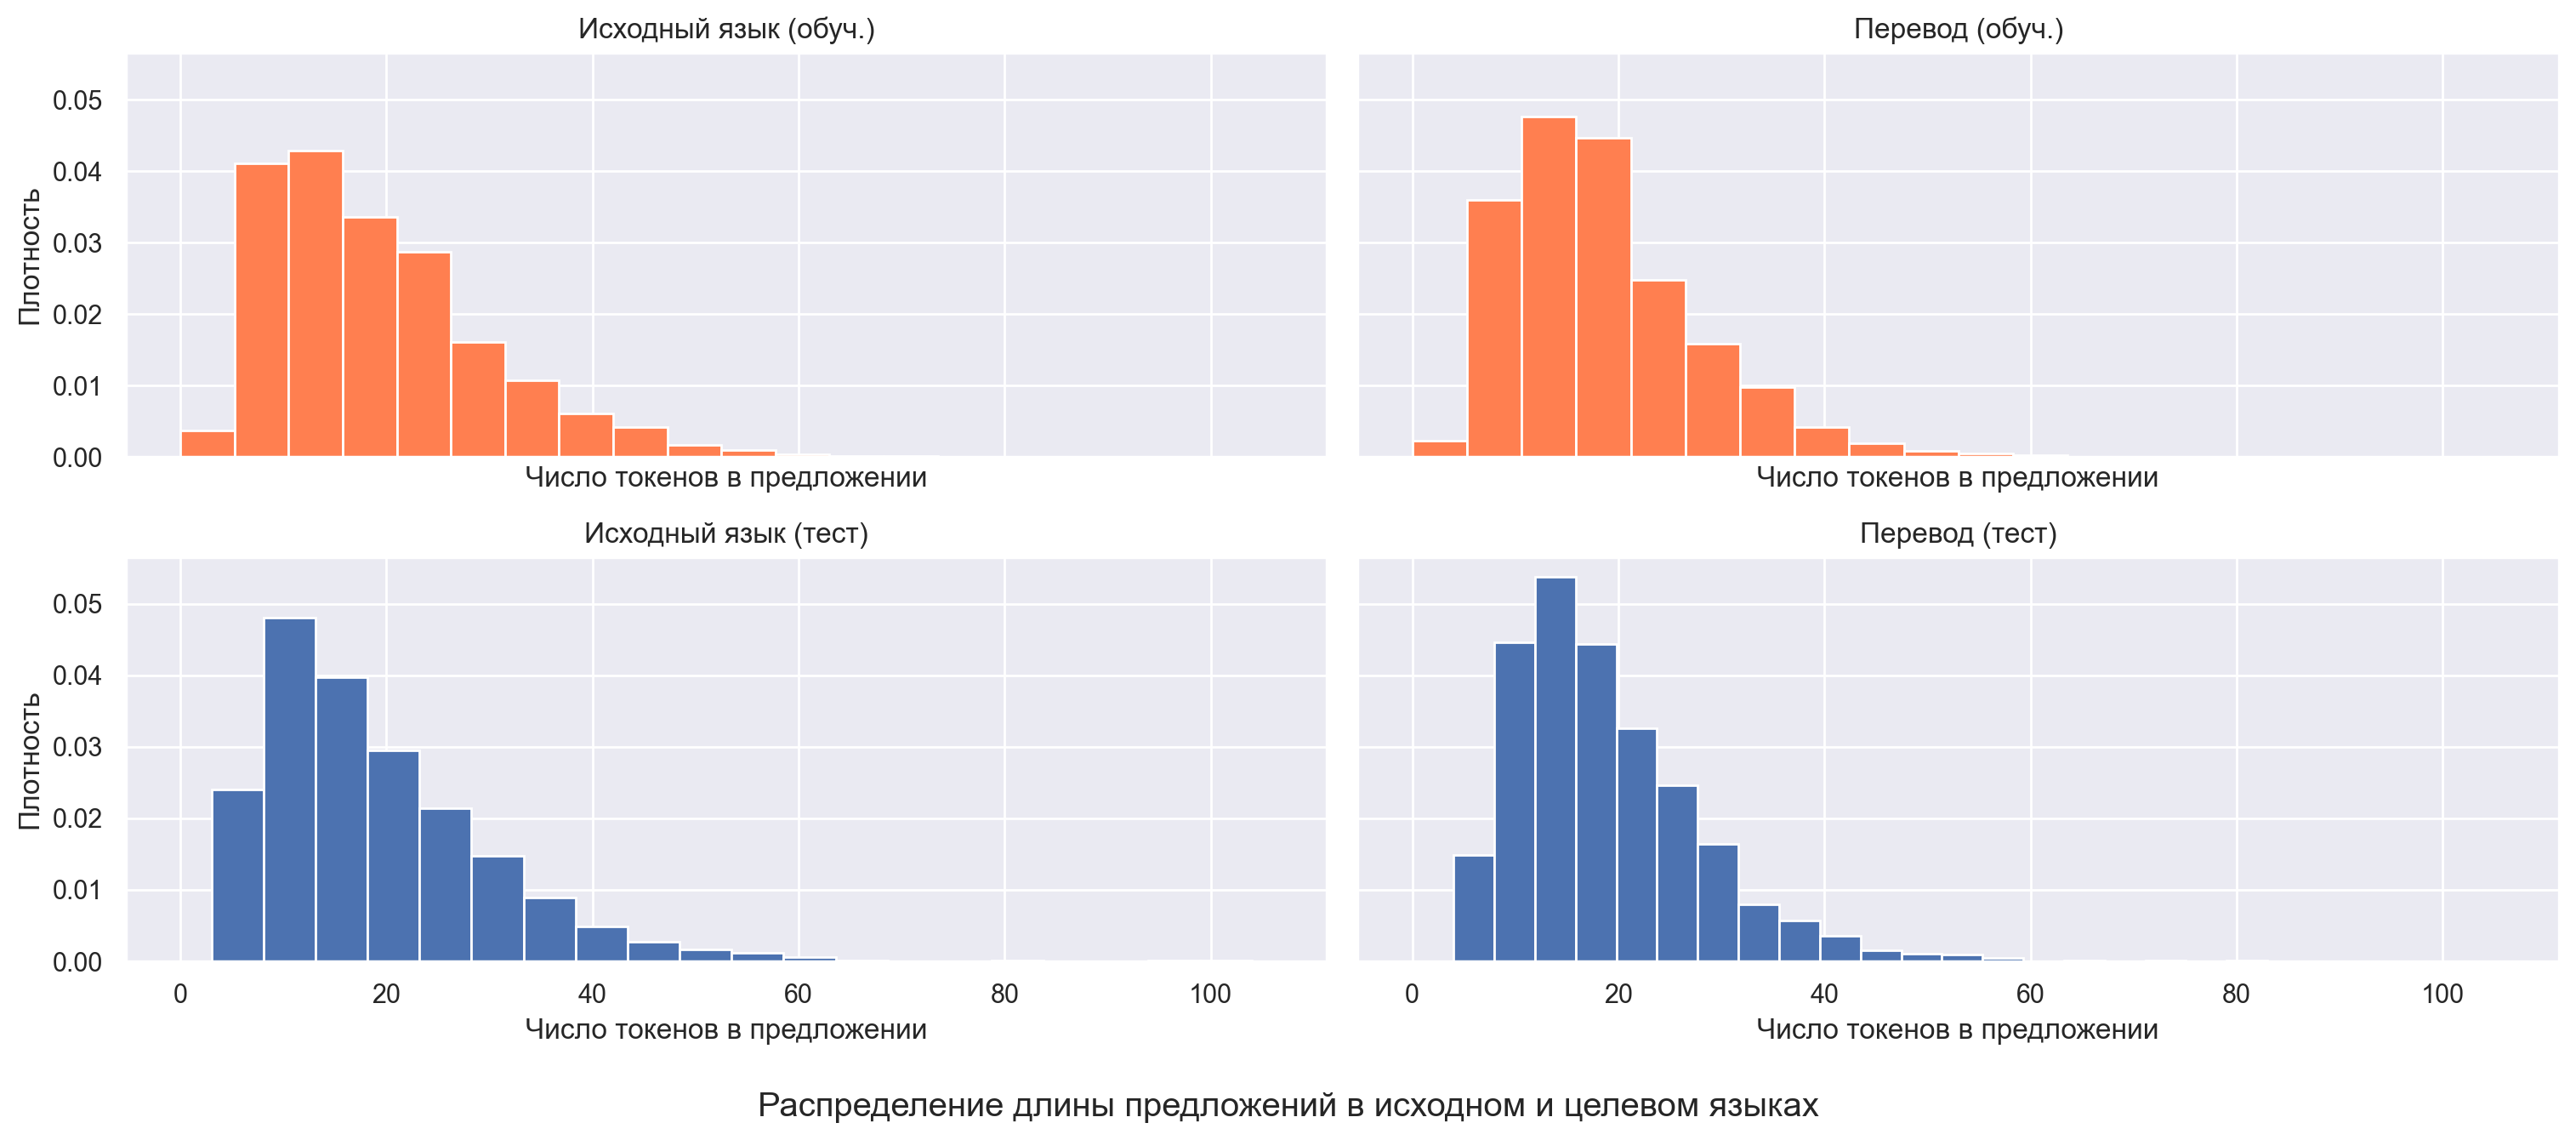

In [ ]:
f, (ax0, ax1) = plt.subplots(2, 2, figsize=(17,7.5), sharex=True, sharey=True)

ax0[0].hist(len_train_inp_by_tok, bins=20, density=True, color='coral')
ax0[0].set_ylabel('Плотность')
ax0[0].set_xlabel('Число токенов в предложении')
ax0[0].set_title('Исходный язык (обуч.)')

ax0[1].hist(len_train_out_by_tok, bins=20, density=True, color='coral')
ax0[1].set_ylabel('')
ax0[1].set_xlabel('Число токенов в предложении')
ax0[1].set_title('Перевод (обуч.)')

ax1[0].hist(len_dev_inp_by_tok, bins=20, density=True)
ax1[0].set_ylabel('Плотность')
ax1[0].set_xlabel('Число токенов в предложении')
ax1[0].set_title('Исходный язык (тест)')

ax1[1].hist(len_dev_out_by_tok, bins=20, density=True)
ax1[1].set_ylabel('')
ax1[1].set_xlabel('Число токенов в предложении')
ax1[1].set_title('Перевод (тест)')

f.suptitle("Распределение длины предложений в исходном и целевом языках", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

Видно, что распределение скошено влево, плюс есть выбросы с очень большой длиной. Но, в целом, плотность схожа во всех выборках.

###  Простая encoder-decoder модель без Attention

Реализуем самую простую encoder-decoder модель (RNN) в качестве **бейзлайна**.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
# базовый класс, будет использоваться далее в качестве родителя

class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """
        Сначала применяем encode а затем decode
        """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # ^-- enc_seq: [batch, time, hid_size], last_state_but_not_really: [batch_size, hid_size]
        
        # последний токен - не последний на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размера, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]

        new_dec_state = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(new_dec_state, prev_gru0_state)

        output_logits = self.logits(new_dec_state)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, output_logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(output_logits)
            
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """
        Генерим токены для перевода
        """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """
        Функция для перевода
        """
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

Немного примеров работы со случайной инициализацией:

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
perpignan golfclub stuttgart dance söl@@ free stubai ira wer@@ qu@@ inform@@ chel@@ tyr@@ blu@@ lam splendi@@ knights sozopol engage gau bla@@ aca washington exit din
way condition@@ lyn unas delivery tranquil pies fra@@ jack@@ ópolis stran@@ adian serving 11@@ floating airport chat@@ mer butt@@ vic montec@@ fort cor@@ jar@@ rica
way lyn entirely mich@@ smart garda ane sigi@@ söl@@ kim@@ cloth@@ appartement stroll crow@@ ute eduardo stein 15 docking eli@@ jet cristina smolen@@ sk terrac@@


In [ ]:
print('Оригинал:')
print('\n'.join([line for line in train_out[:3]]))

Оригинал:
free private parking is available on site .
guests can find many bars and restaurants within a 5 - minute walk .
hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .


### Loss function

Реализуем следующий лосс (*cross-entropy*), чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ — это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг.

In [ ]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    return: скаляр (значение лосса для минимизации)
    """
    mask = model.out_voc.compute_mask(out)  # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # выходы модели, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токенов на всех шагах
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)  # [batch_size, out_len, num_tokens]
   
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)  # [batch_size, out_len]

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask].mean()

In [ ]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5463, device='cuda:0', grad_fn=<NegBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных **n-grams** для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Функция считает метрику BLEU: https://en.wikipedia.org/wiki/BLEU
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

Немного протестируем реализацию метрики:

In [ ]:
# почистим кэш при необходимости

# import gc
# gc.collect()

# torch.cuda.empty_cache()

In [ ]:
compute_bleu(model, dummy_translations, train_out[:3])  # полное несовпадение

0

In [ ]:
compute_bleu(model, dev_inp, dev_out)  # на тестовой выборке

0.0014397909622784772

In [ ]:
compute_bleu(model, dev_inp[:1000], dev_out[:1000])  # на тестовой выборке каждый 1000-й объект

0.003433939317158459

In [ ]:
compute_bleu(model, train_inp[:len(train_inp):2], train_out[:len(train_inp):2])  # на обуч. выборке каждый 2-й объект

0.0003096793506698338

*Кажется, все работает корректно.*

### Training loop

Напишем цикл обучения и подсчитаем метрики, в конце — assert по качеству.

In [ ]:
def seed_everything(seed):
    """
    Функция фискирует максимум сидов.
    Это понадобится, чтобы сравнение оптимизаторов было корректным.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
# задаем гиперпараметры и объекты для метрик
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 25000

best_bleu = -1
best_iter = -1

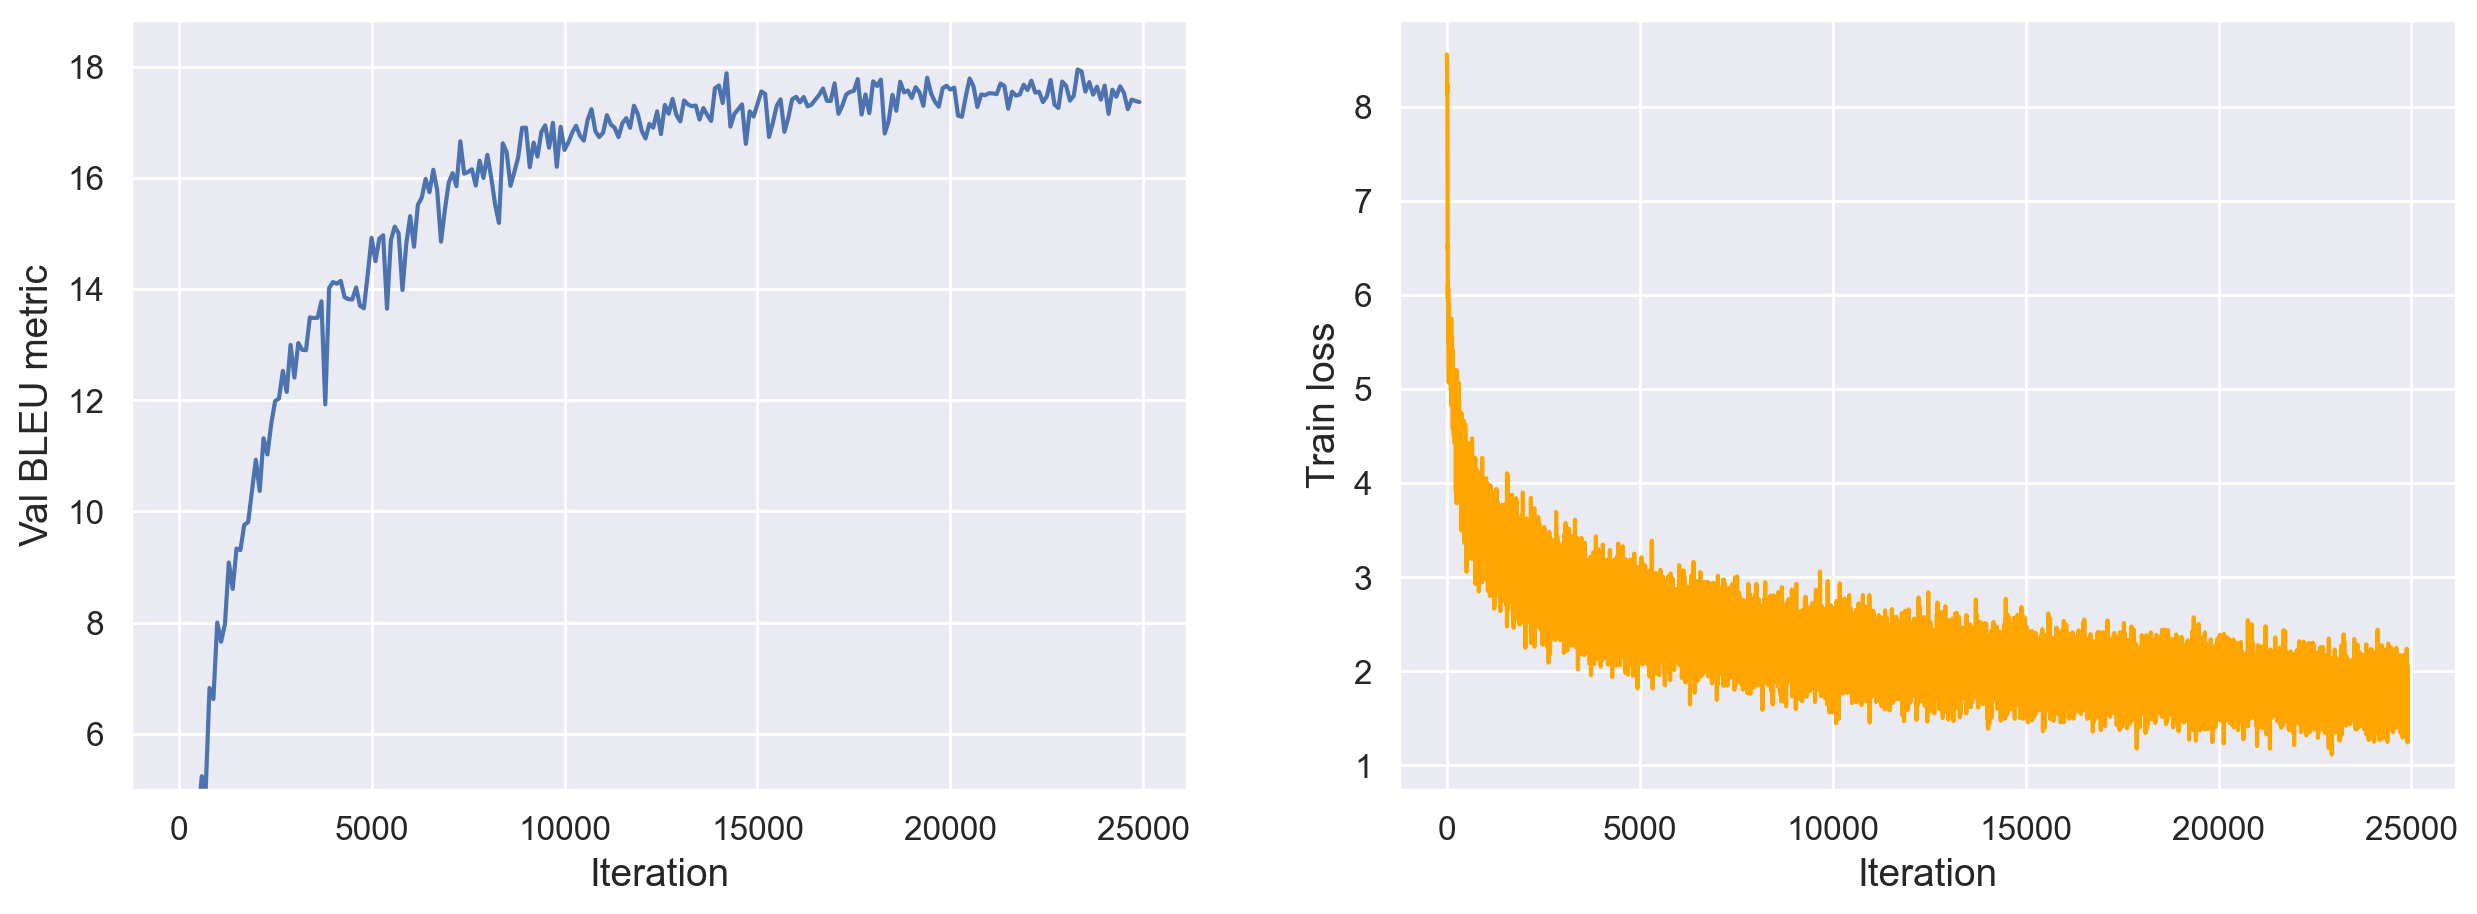

Последний лосс на 100 итер.: 1.7503,             
Последнее BLEU: 17.3624


100%|██████████| 25000/25000 [38:15<00:00, 10.89it/s]

CPU times: total: 2h 4min 51s
Wall time: 38min 15s


In [ ]:
%%time

for iter_ in trange(num_iter):
    # отправляем модель в режим обучения
    model.train(True)
    # определяем батч исходного языка и целевого
    batch_idx = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_idx]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_idx]).to(device)

    # считаем лосс, делаем бэкпроп
    opt.zero_grad()
    loss = loss_function(model, batch_inp, batch_out)
    loss.backward()
    opt.step()

    # записываем лосс
    metrics['train_loss'].append((iter_, loss.item()))

    if iter_ % 100 == 0:
        # валидируемся каждые 100 итераций
        # отправляем модель в режим валидации
        model.train(False)

        # считаем метрику BLEU на тесте
        bleu = compute_bleu(model, dev_inp, dev_out)
        # записываем метрику BLEU
        metrics['dev_bleu'].append((iter_, bleu))

        # если в этот раз BLEU самая высокая, (пере)сохраняем лучшую модель
        if bleu > best_bleu:
            best_bleu = bleu
            best_iter = iter_
            torch.save(model.state_dict(), 'best-rnn.pt')
        
        # рисуем графики обучения
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # рисуем BLEU
        plt.subplot(1, 2, 1)
        plt.xlabel("Iteration", fontsize=14)
        plt.xticks(fontsize=12)
        plt.ylabel("Val BLEU metric", fontsize=14)
        plt.yticks(fontsize=12)
        plt.plot([p[0] for p in metrics['dev_bleu']], 
                 [p[1] for p in metrics['dev_bleu']]
                 )

        if bleu > 5:
            # ограничиаем по оси Y, чтобы график был красивее
            plt.ylim(bottom=5)
        
        # рисуем лосс 
        plt.subplot(1, 2, 2)
        plt.xlabel("Iteration", fontsize=14)
        plt.xticks(fontsize=12)
        plt.ylabel("Train loss", fontsize=14)
        plt.yticks(fontsize=12)
        plt.plot(
            [p[0] for p in metrics['train_loss']],
            [p[1] for p in metrics['train_loss']],
            color="orange")

        plt.show()

        # считаем лосс на последних 100 итер. и выводим его, а также BLEU
        last_loss = np.mean([i[1] for i in metrics['train_loss'][-100:]])
        print(f'Последний лосс на 100 итер.: {round(last_loss, 4)}, \
            \nПоследнее BLEU: {round(bleu, 4)}', flush=True)


In [ ]:
print('Лучший BLEU:', best_bleu, '\nЛучшая итерация:', best_iter)

Лучший BLEU: 17.948395804096794 
Лучшая итерация: 23300


In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "Получилось плохо! Возможно, что-то пошло не так."

Посмотрим на генерации (переводы):

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
car rental and laundry services are available at a surcharge .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
ka@@ pp@@ ye is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a garden , a terrace and a sun terrace , villa oas@@ i offers self - catering accommodation with a terrace and a garden .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
hostel cc@@ í@@ s apartment is located in budapest .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with towels .



In [ ]:
print('Параметров у простой RNN модели:', sum([p.numel() for p in model.parameters()]))

Параметров у простой RNN модели: 2186169


## Attention is all you need

###  Более сложная encoder-decoder модель с Attention

Усовершенствуем базовую модель: сначала напишем слой **Attention**, а потом внедрим его в уже существующий шаблон.

#### Attention layer

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 

        # линейный слой для энкодера или linear_e 
        self.linear_enc = nn.Linear(enc_size, hid_size)
        # линейный слой для декодера или linear_d 
        self.linear_dec = nn.Linear(dec_size, hid_size)
        # выходной линейный слой или linear_out
        self.linear_out = nn.Linear(hid_size, 1)
        # гиперб. тангенс
        self.tanh = nn.Tanh()
        # софтмакс
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ и веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        # определим размеры для энкодера
        batch_size, ninp, enc_size = enc.shape

        # считаем логиты
        h_enc = self.linear_enc(enc)
        h_dec = self.linear_dec(dec).reshape(-1, 1, self.hid_size)

        h_out = self.tanh(h_enc + h_dec)
        h_out = self.linear_out(h_out)

        # применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        h_out[torch.where(inp_mask == False)] = -1e9

        # применим softmax
        probs = self.softmax(h_out.reshape(batch_size, ninp))

        # считаем выход attention слоя, используя enc состояния и вероятности
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(axis=1)

        return attn, probs

#### Seq2seq model with attention

Теперь используем уровень внимания для построения сети. Самый простой способ реализовать внимание — использовать его на этапе декодирования.

На каждом шаге будем использовать предыдущее состояние декодера, и слой Attention.

*Примечание*: в оригинальной статье, в которой была представлена идея Attention ([Neural machine translation by jointly learning to align and translate](https://arxiv.org/pdf/1409.0473.pdf)) авторы рекомендовали использовать **LSTM** и **bidirectional** тип encoder-а.
В реализации ниже опционально добавлены два этих момента. В ходе экспериментов было установлено, что так модель действительно учится лучше.

In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128,
                 bidirectional=False, type_of_rnn='GRU'):
        """
        Модель с Attention
        """
        nn.Module.__init__(self)

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.name = name
        self.emb_size = emb_size
        self.attn_size = attn_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

        # если используется bidirectional тип, то входное число параметров увеличивается на hid_size
        self.dec_start = nn.Linear(hid_size + hid_size * bidirectional, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size + hid_size * bidirectional, hid_size)
        self.attn = AttentionLayer(name, hid_size + hid_size * bidirectional, hid_size, attn_size)

        if type_of_rnn == 'GRU':
            self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=bidirectional)
        elif type_of_rnn == 'LSTM':
            # в оригинальной статье про attention советовалось использовать
            # LSTM в качестве RNN-based-архитектуры и bidirectional тип encoder-а
            self.enc0 = nn.LSTM(emb_size, hid_size, batch_first=True, bidirectional=bidirectional)
        else:
            assert False, f'Данный тип RNN: {type_of_rnn} не поддерживается'

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        
        # делаем encode
        inp_emb = self.emb_inp(inp)
        
        # применяем attention слой для скрытых состояний декодера
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # обращаемся к прошлой архитектуре-родителю и берем с помощью нее значение
        # dec_start (list)
        [dec_start] = super().encode(inp, **flags)
        # считаем маску для скрытых состояний
        enc_mask = self.out_voc.compute_mask(inp)
        # это должны быть вероятности, поэтому берем 1 индекс (см. что возвращает AttentionLayer)
        first_attn_probas = self.attn(enc_seq, dec_start, enc_mask)[1]
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, enc_mask, first_attn_probas]
        return first_state

   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """
        
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, probs = self.attn(enc_seq, prev_gru0_state, enc_mask)
        
        h_out = self.emb_out(prev_tokens)
        
        # объединяем векторы атеншна и эмбедингов декодировщика
        h_out = torch.cat([attn, h_out], dim=-1)
        h_out = self.dec0(h_out, prev_gru0_state)
        
        # новое состояние декодера
        new_dec_state = [h_out, enc_seq, enc_mask, probs]
        # тензор логитов
        output_logits = self.logits(h_out)

        return new_dec_state, output_logits


### Обучение модели

Обучим `AttentiveModel`:

In [ ]:
torch.cuda.empty_cache()  # очистим кэш

In [ ]:
# задаем гиперпараметры и объекты для метрик
metrics = {'train_loss': [], 'dev_bleu': [] }

# увеличиваем размерности эмбедингов
attentive_model = AttentiveModel('attentive_model.pt', inp_voc, out_voc,
                                 emb_size=256, hid_size=256, attn_size=256,
                                 bidirectional=True, type_of_rnn='LSTM').to(device)
# ставим другой оптимизатор
opt = torch.optim.AdamW(attentive_model.parameters(), lr=1e-3, weight_decay=1e-4)
# делаем больше batch_size
batch_size = 64

num_iter = 25000

best_bleu = -1
best_iter = -1

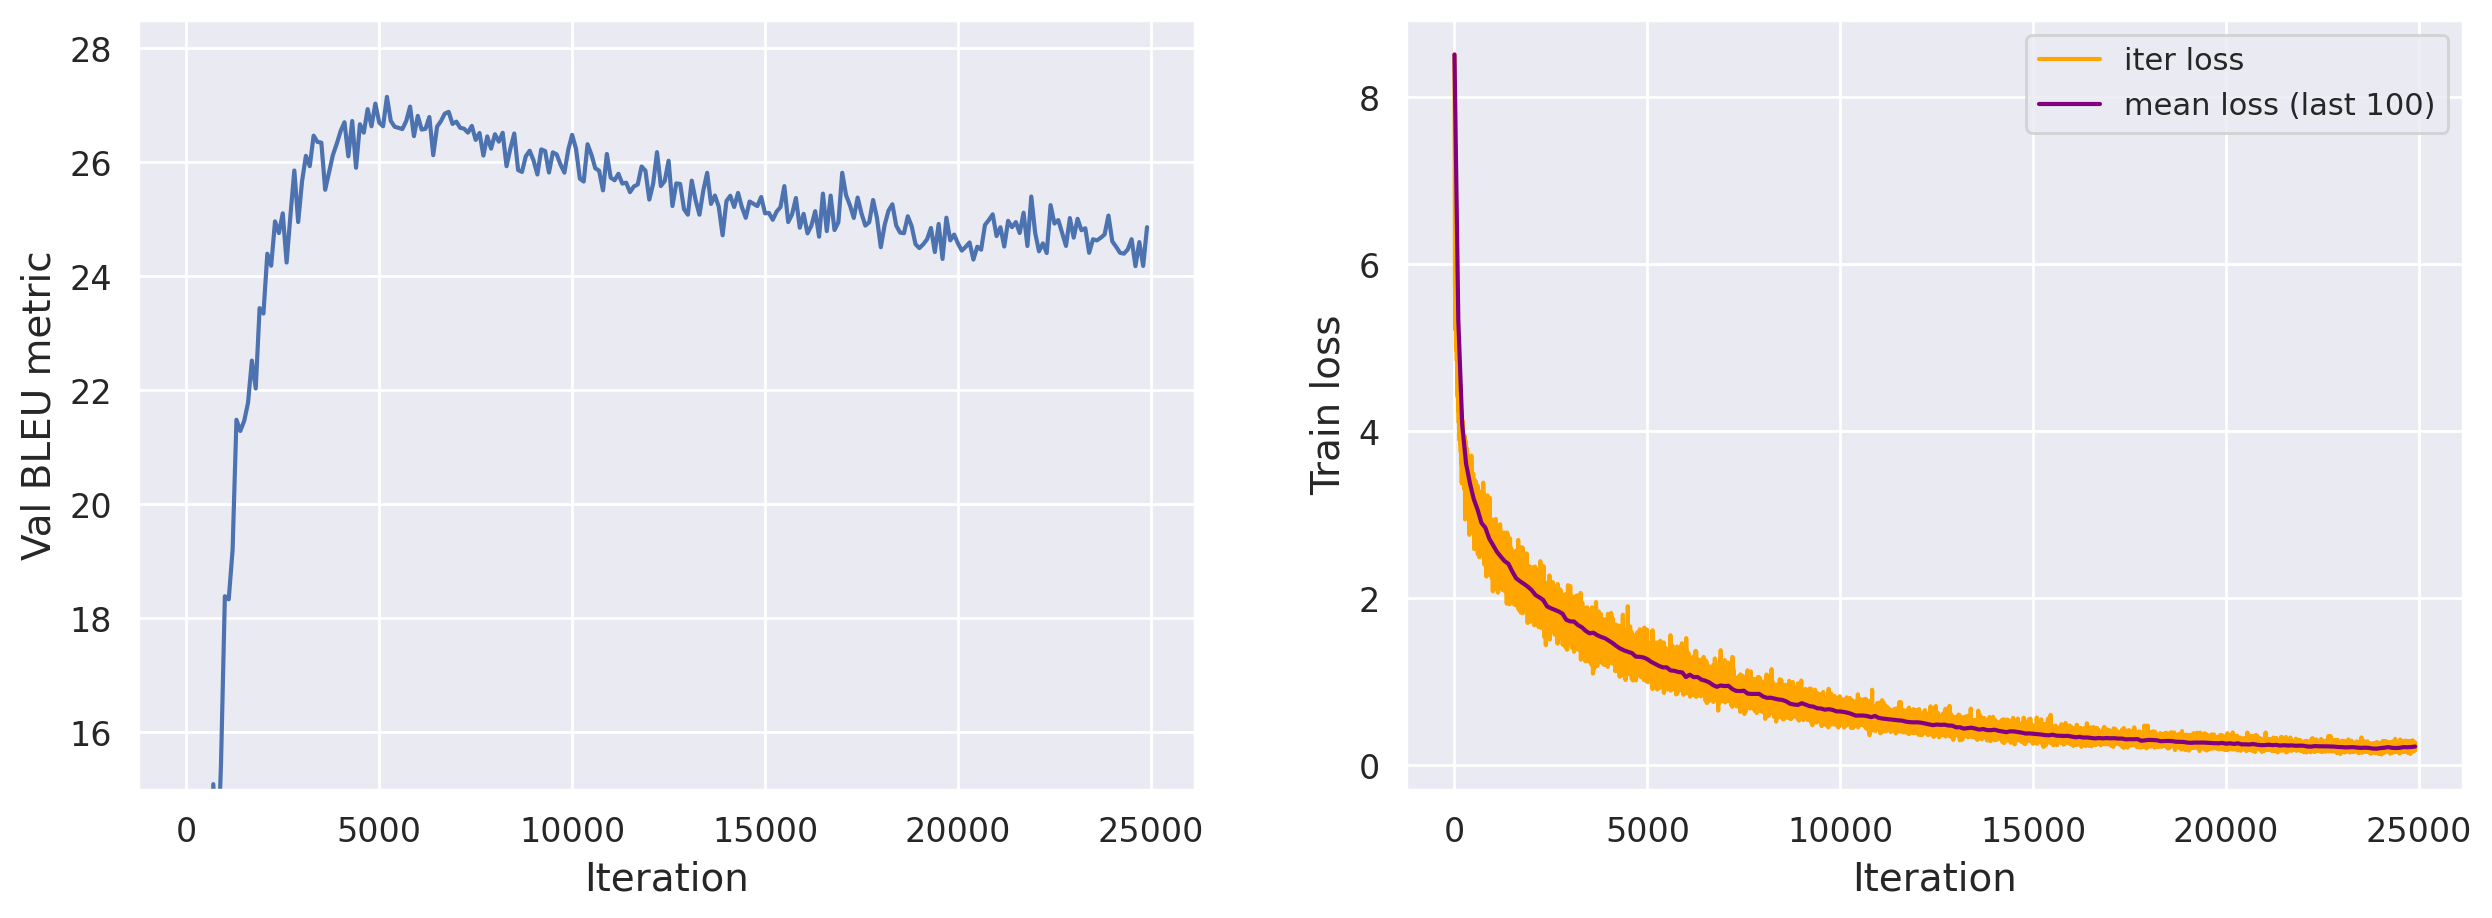

Последний лосс на 100 итер.: 0.2242,             
Последнее BLEU: 24.8619


100%|███████████████████████████████████| 25000/25000 [1:38:24<00:00,  4.23it/s]

CPU times: user 1h 45min 26s, sys: 1min 54s, total: 1h 47min 21s
Wall time: 1h 38min 24s


In [ ]:
%%time

mean_loss = []

for iter_ in trange(num_iter, ncols=80):
    # отправляем модель в режим обучения
    attentive_model.train(True)
    # определяем батч исходного языка и целевого
    batch_idx = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_idx]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_idx]).to(device)

    # считаем лосс, делаем бэкпроп
    opt.zero_grad()
    loss = loss_function(attentive_model, batch_inp, batch_out)
    loss.backward()
    opt.step()

    # записываем лосс
    metrics['train_loss'].append((iter_, loss.item()))

    if iter_ % 100 == 0:
        # валидируемся каждые 100 итераций
        # отправляем модель в режим валидации
        attentive_model.train(False)

        # считаем метрику BLEU на тесте
        bleu = compute_bleu(attentive_model, dev_inp, dev_out)
        # записываем метрику BLEU
        metrics['dev_bleu'].append((iter_, bleu))

        # если в этот раз BLEU самая высокая, (пере)сохраняем лучшую модель
        if bleu > best_bleu:
            best_bleu = bleu
            best_iter = iter_
            torch.save(attentive_model.state_dict(), attentive_model.name)
        
        # рисуем графики обучения
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # рисуем BLEU
        plt.subplot(1, 2, 1)
        plt.xlabel("Iteration", fontsize=14)
        plt.xticks(fontsize=12)
        plt.ylabel("Val BLEU metric", fontsize=14)
        plt.yticks(fontsize=12)
        plt.plot([p[0] for p in metrics['dev_bleu']], 
                 [p[1] for p in metrics['dev_bleu']]
                 )

        if bleu > 15:
            # ограничиаем по оси Y, чтобы график был красивее
            plt.ylim(bottom=15)
        
        # считаем лосс на последних 100 итер. и записываем его
        last_loss = np.mean([i[1] for i in metrics['train_loss'][-100:]])
        mean_loss.append(last_loss)

        # рисуем лосс 
        plt.subplot(1, 2, 2)
        plt.xlabel("Iteration", fontsize=14)
        plt.xticks(fontsize=12)
        plt.ylabel("Train loss", fontsize=14)
        plt.yticks(fontsize=12)
        plt.plot(
            [p[0] for p in metrics['train_loss']],
            [p[1] for p in metrics['train_loss']],
            color="orange",
            label='iter loss')
        plt.plot(
            np.arange(0, iter_ + 1, 100),
            mean_loss,
            color="purple",
            label='mean loss (last 100)')
        plt.legend(loc="best")

        plt.show()

        # выводим лосс на последних 100 итер., а также BLEU
        print(f'Последний лосс на 100 итер.: {round(last_loss, 4)}, \
            \nПоследнее BLEU: {round(bleu, 4)}', flush=True)


После 5 тыс. итераций модель начала переобучаться. В целом, при обучении можео было ограничиться ими.

In [ ]:
print('Лучший BLEU:', best_bleu, '\nЛучшая итерация:', best_iter)

Лучший BLEU: 27.147095009398825 
Лучшая итерация: 5200


In [ ]:
one_more_bleu = compute_bleu(attentive_model, dev_inp, dev_out)
print(one_more_bleu)
    
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"

24.790781191157592


Примеры переводов:

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], attentive_model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests are common guest house in the communal kitchen and shared lounge .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental service is provided , as well as free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
kis@@ samos is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
featuring a shared outdoor pool , a sun terrace , sun terrace , sun terrace , sun - villa richmond features a garden , outdoor pool and sun terrace , sun terrace and a sun terrace , sun terrace and a sun terrace , sun terrace and a sun terrace , sun terrace and a sun terrace , sun terrace , an outdoor pool , a sun terrace and sun terraces are a 5 - minute walk from lido .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах о

In [ ]:
print('Параметров у RNN (LSTM) модели с attention:', sum([p.numel() for p in attentive_model.parameters()]))

Параметров у RNN (LSTM) модели с attention: 8231546


*Параметров стало в 4 раза больше, но, в основном, засчет увеличения размерности эмбедингов.*

## Дообучим трансформер (large language model) из huggingface

Это метод, который должен дать лучший результат.
 
Возьмем модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучим на наших данных и посмотрим на качество.

In [ ]:
# !pip install transformers[sentencepiece] datasets sacremoses accelerate -q

### Подготовка данных и модели
#### Вновь EDA

В посмотрим на **распределение длин предложений по символам** — это пригодится далее, чтобы понять, по какому символу можно отрезать длинные предложения (**truncate**). Для больших моделей это важно.

In [5]:
# собираем данные в два списка - русские и английские предложения
draw_data = {
             "ru": [],
             "en": []
             }

for line in open('data.txt'):
    en_line, ru_line = line.strip().split('\t')
    draw_data['ru'].append(ru_line)
    draw_data['en'].append(en_line)

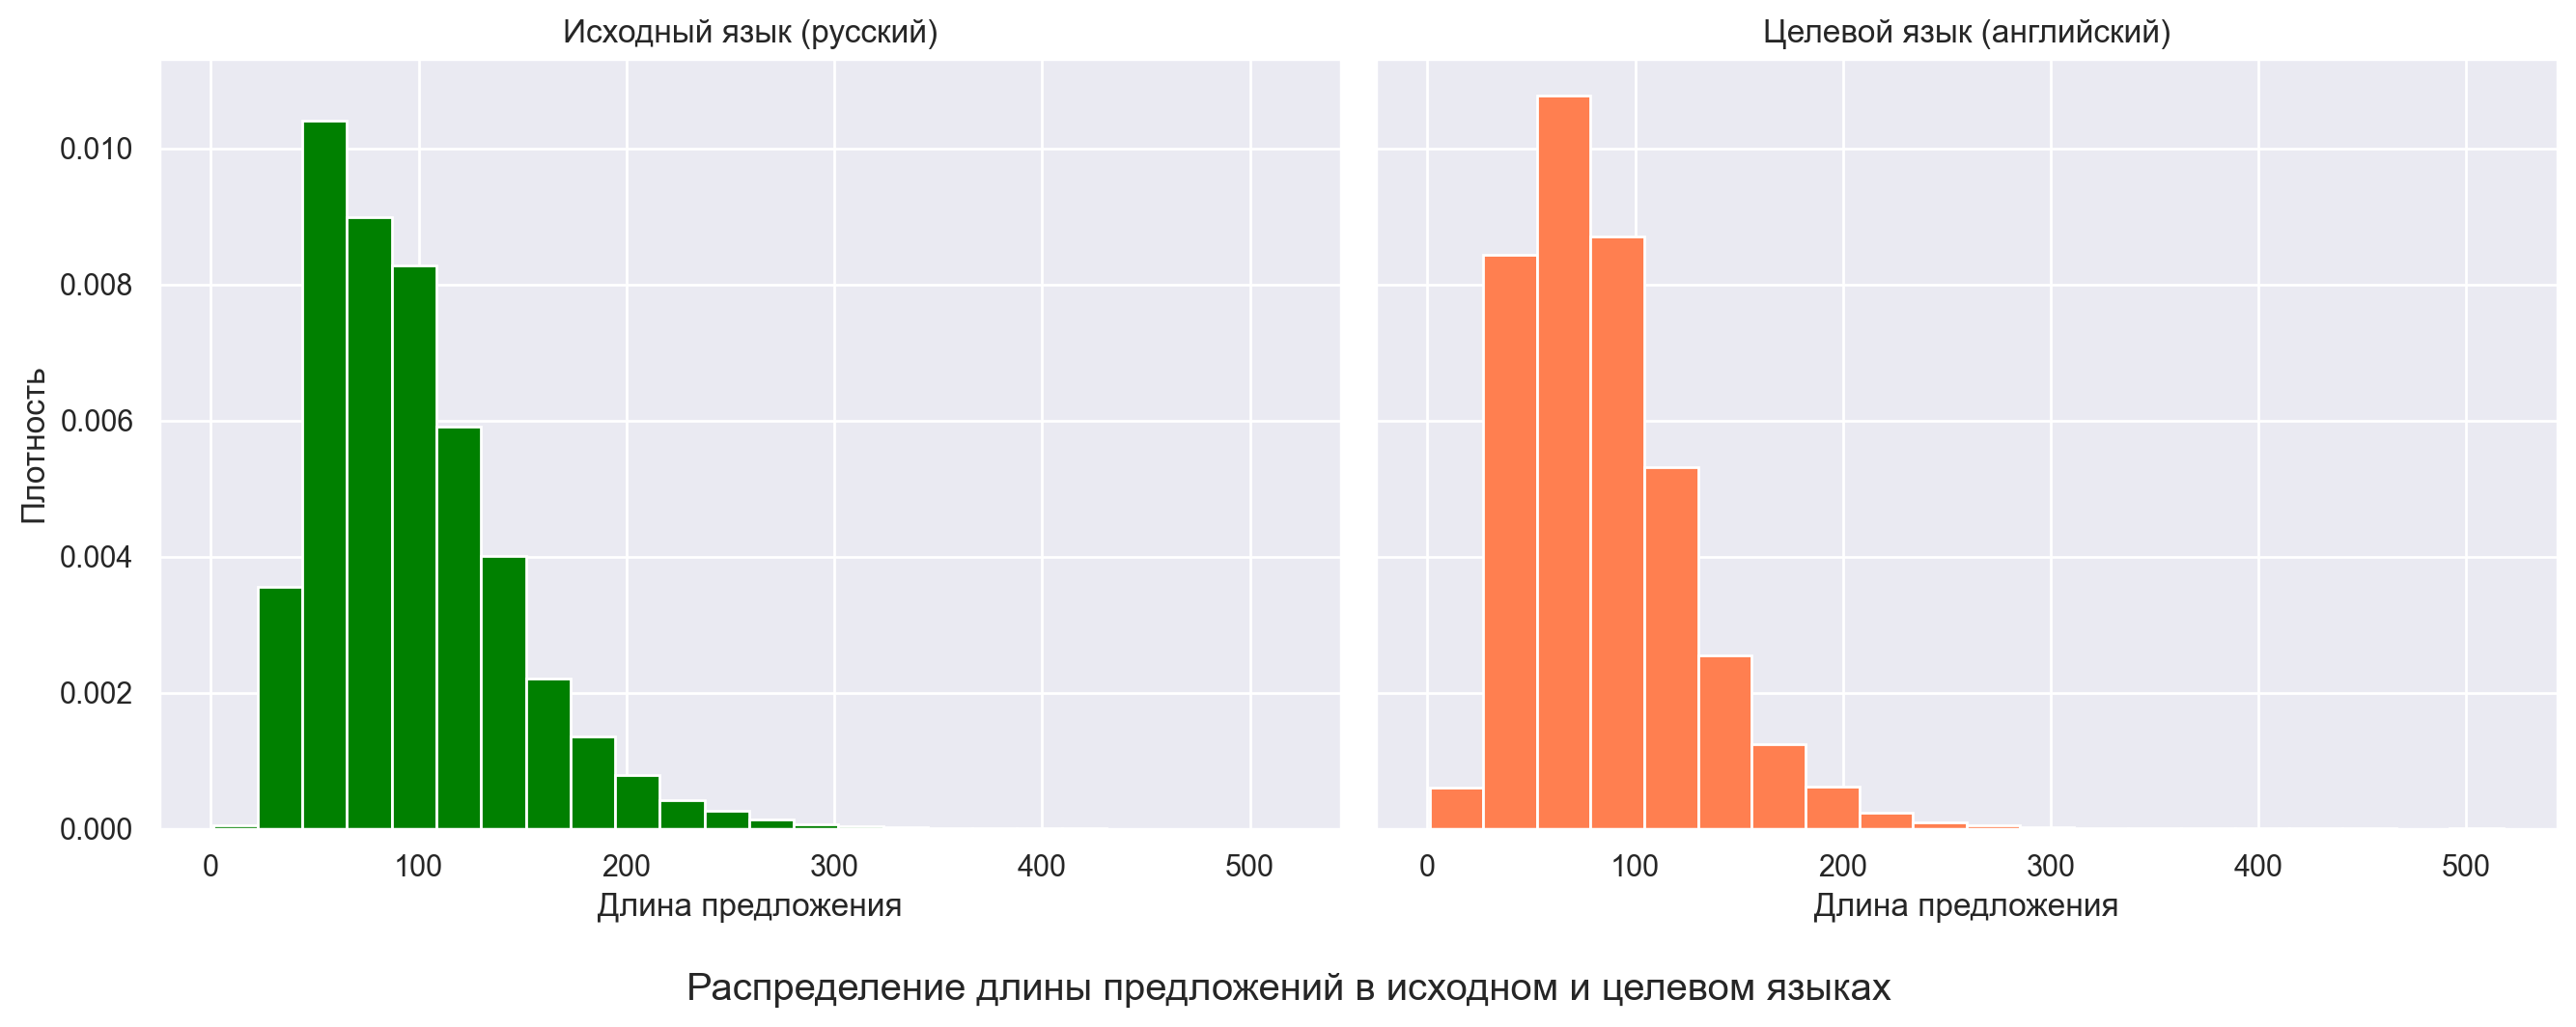

In [6]:
# считаем длину по числу символов и строим гистограммы
len_data_inp = list(map(len, draw_data['ru']))
len_data_out = list(map(len, draw_data['en']))

f, ax0 = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=True)

ax0[0].hist(len_data_inp, bins=20, density=True, color='green')
ax0[0].set_ylabel('Плотность')
ax0[0].set_xlabel('Длина предложения')
ax0[0].set_title('Исходный язык (русский)')

ax0[1].hist(len_data_out, bins=20, density=True, color='coral')
ax0[1].set_ylabel('')
ax0[1].set_xlabel('Длина предложения')
ax0[1].set_title('Целевой язык (английский)')

f.suptitle("Распределение длины предложений в исходном и целевом языках", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [10]:
cut = 180

print(f'Потеряем, если отрезать больше {cut} символов:')

print(f'\nВ русском: {np.sum(np.array(len_data_inp) > cut) / len(len_data_inp)}, \
    \nВ английском: {np.sum(np.array(len_data_out) > cut) / len(len_data_out)}')

Потеряем, если отрезать больше 180 символов:

В русском: 0.05436,     
В английском: 0.02776


In [26]:
# пример большого предложения
print(np.array(draw_data['ru'])[np.array(len_data_inp) > cut][0])

По утрам для гостей сервируется континентальный завтрак «шведский стол», состоящий из булочек, выпечки, фруктов, мюслей и мясного ассорти. Стоимость завтрака составляет 9,5 фунтов стерлингов.


Если отрезать предложения по 180 символам, то больше этого порога окажутся около 5% русских и 3% английских предложений. В целом, звучит как баланс между скоростью работы и обучения и сохранением содержания. Грубо говоря, отрежем по 95% квантилю для русского языка (оригинала).

#### Подготовка данных

Далее подготовим данные в специальный объект `DatasetDict` от Hugging Face. 

Для этого в начале соберем данные в `pd.DataFrame` с двумя столбцами: `id`: уникальные номера переводов и `translation`: сам перевод — словарь с парами предложений по ключам `ru` и `en`.

Затем сохраним датасет в формате `json`, чтобы считать функцией из библиотеки `datasets`.

In [4]:
dict_data = {
             "id": [],
             "translation": []
             }

for line in open('data.txt'):
    en_line, ru_line = line.strip().split('\t')

    dict_data["id"].append(str(i))
    dict_data["translation"].append({"ru": ru_line, "en": en_line})

In [5]:
pd_data = pd.DataFrame.from_dict(dict_data)
pd_data

,id,translation
0,0,"{'ru': 'Отель Cordelia расположен в Тбилиси, в..."
1,1,{'ru': 'В числе удобств лоджа Tupirmarka кругл...
2,2,{'ru': 'Апартаменты Naigao Xiaowo расположены ...
3,3,{'ru': 'В вашем распоряжении также телевизор и...
4,4,{'ru': 'Номер оснащен кондиционером и спутнико...
...,...,...
49995,49995,{'ru': 'Просторные номера с кондиционером выхо...
49996,49996,{'ru': 'Минская кольцевая автомобильная дорога...
49997,49997,{'ru': 'В собственной ванной комнате установле...
49998,49998,{'ru': 'За 15 минут вы доедете до центра город...


In [6]:
# сохраняем в json
pd_data.to_json('json_data.json', orient='records', lines=True)

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer
from accelerate import Accelerator

from datasets import load_dataset
from transformers import pipeline, get_scheduler

In [10]:
# считываем данные в формат Hugging Face
data_hf = load_dataset("json", data_files="json_data.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-5fa187f8dfffa699/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# формат DatasetDict от Hugging Face
data_hf

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 50000
    })
})

In [12]:
# разделим датасет на трейн и тест в той же пропорции, как выше, и с таким же сидом
split_datasets = data_hf["train"].train_test_split(test_size=3000, seed=42)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 47000
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 3000
    })
})

In [13]:
# переименуем поле "test" на "validation"
split_datasets["validation"] = split_datasets.pop("test")

In [14]:
# пример данных из обучающей выборки
split_datasets["train"][1]["translation"]

{'ru': 'Расстояние до аэропорта имени Пинту Мартинса составляет 7 км.',
 'en': 'Pinto Martins Airport is located 7 km away.'}

#### Модель — opus-mt-ru-en

Будем использовать модель **opus-mt-ru-en** от **Helsinki-NLP** специально для задачи NMT с русского на английский.

In [15]:
model_checkpoint = 'Helsinki-NLP/opus-mt-ru-en'
translator = pipeline("translation", model=model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

Посмотрим на *пример перевода модели до дообучения*:

In [16]:
# пример данных
split_datasets["train"][1]["translation"]

{'ru': 'Расстояние до аэропорта имени Пинту Мартинса составляет 7 км.',
 'en': 'Pinto Martins Airport is located 7 km away.'}

In [17]:
# пример перевода
translator('Расстояние до аэропорта имени Пинту Мартинса составляет 7 км.')

[{'translation_text': 'The distance to Pinto Martins Airport is 7 km.'}]

In [18]:
max_length = 180  # 95% квантиль

def preprocess_function(examples):
    '''
    Функция для предобработки (токенизации) датасета
    все предложения, поступающие на вход, обрезаются по max_length символу
    '''
    inputs = [ex["ru"] for ex in examples["translation"]]
    targets = [ex["en"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [19]:
# токенизируем
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

Map:   0%|          | 0/47000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [20]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 47000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
})

In [21]:
# определяем модель и дата коллейтор
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [22]:
# пример того, как будут выглядеть батчи
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [23]:
batch["labels"]  # видно, как применяется паддинг

tensor([[  542,   599,  1448, 17535,    23, 27866,    34,  7264,   304,  8762,
          1449,     3,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100],
        [   86, 13506, 31653, 55595,    23,   458, 14366,  1115,    34,   239,
          3878,    18,  6441,    65,     4, 29880, 23343,     8,   215,  3878,
            18,  7146,    65,     4,  9503,  5277,     5, 11875,    68, 10208,
          8153,     3,     0]])

#### Метрика

Будем испольщовать ту же реализацию метрики BLEU, что и выше, но видоизменим входы в нее в соответствии с новым пайплайном, т.к. новая модель применяется по-другому.

In [26]:
def compute_bleu_from_lists(translations, actual, **flags):
    """
    :param translations: list[str] с переводами модели
    :param actual: list[str] с реальными переводами (таргет)

    В функцию передаются исходные предложения и перевод в "человеческом" виде.
    В остальном функция ничем не отличается от той, что использовалась выше.
    """
    with torch.no_grad():
        bleu = corpus_bleu(
            [[ref.split()] for ref in actual],          # list(list(list(str)))  
            [trans.split() for trans in translations],  # list(list(str))  
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100
        return bleu

Посмотрим на примеры работы метрики:

In [27]:
# на хорошем переводе из примера HF
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
        "This plugin allows you to automatically translate web pages between several languages."
]

compute_bleu_from_lists(predictions, references)

48.83499409416459

In [28]:
# идеальный перевод (сам с собой)
# не равен 1 из-за сглаживания
compute_bleu_from_lists(draw_data['en'], draw_data['en'])

99.99552424914641

#### Основные объекты для обучения

Не будем пользоваться объектом `Trainer` из `transformers`, поскольку процесс обучения через него сложно отслеживать. 

Поэтому определим `DataLoader`, оптимизатор и т.д. из `PyTorch`:

In [29]:
# авторизация в HF Hub, чтобы после обучения загрузить туда обученную модель
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [87]:
# определяем даталодеры
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=64,  
    num_workers=12,
    pin_memory=True
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], 
    collate_fn=data_collator, 
    batch_size=64,
    num_workers=12,
    pin_memory=True
)

In [88]:
# переопределяем модель, т.к. раньше нужно было иниц-ть ее, чтобы положить в DataCollator
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

metrics = {'train_loss': [], 'dev_bleu': []}

best_bleu = -1
best_iter = -1

In [89]:
# используем Accelerator от HF для ускорения работы (DeepSpeed под капотом)
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [90]:
# определяем параметры обучения
num_train_epochs = 4
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

# шедулер линейно снижается от lr до 0 к последней итерации
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

print('Число итераций за время обучения:', num_training_steps)

Число итераций за время обучения: 2940


In [37]:
# получаем имя репозитория с моделью
from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-hotels-ru-to-en-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'VladRub1/marian-finetuned-hotels-ru-to-en-accelerate'

In [38]:
# клонируем репозиторий с моделью в рабочую директорию
output_dir = "marian-finetuned-hotels-ru-to-en-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

Cloning https://huggingface.co/VladRub1/marian-finetuned-hotels-ru-to-en-accelerate into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.5k/291M [00:00<?, ?B/s]

Download file source.spm:   2%|1         | 18.4k/1.03M [00:00<?, ?B/s]

Download file target.spm:   1%|          | 7.37k/784k [00:00<?, ?B/s]

Clean file target.spm:   0%|          | 1.00k/784k [00:00<?, ?B/s]

Clean file source.spm:   0%|          | 1.00k/1.03M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/291M [00:00<?, ?B/s]

In [39]:
def postprocess(predictions, labels):
    '''
    Функция для постобработки выхода модели.
    Преобразует выходы модели (тензоры) в реальные предложения на естественном языке.
    Функция взята из: https://huggingface.co/course/chapter7/4?fw=pt
    и переделана под собственные нужды
    '''
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    # т.е. обрабатываем паддинг
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    return decoded_preds, decoded_labels

In [40]:
def compute_bleu_hf(model, eval_dataloader, device='cuda', max_length=180):
    '''
    Вспомогательная функция, которая считает метрику BLEU на валидации
    согласно пайплайну моделей из Hugging Face
    Код для валидации модели позаимствован из: https://huggingface.co/course/chapter7/4?fw=pt
    и интегрирован под другие оригинальные функции
    '''
    # переводим модель в режим валидации
    model.train(False)

    # заводим контейнеры для предложений-переводов
    eval_batches_pred = []
    eval_batches_labels = []

    for batch in tqdm(eval_dataloader, ncols=80):
        with torch.no_grad():
            batch.to(device)
            # генерируем токены
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=max_length,  # 180
            )
        # забираем нужную часть предсказания - поле labels
        labels = batch["labels"]

        # обрабатываем выходы
        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        # превращаем токены в человеческий вид
        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)

        # добавляем сгенерированные и правильные переводы
        eval_batches_pred.extend(decoded_preds)
        eval_batches_labels.extend(decoded_labels)

    # считаем BLEU
    bleu = compute_bleu_from_lists(eval_batches_pred, eval_batches_labels)
    # также возвращаем предложения для того, чтобы посмотреть на них при необходимости
    return bleu, eval_batches_pred, eval_batches_labels

Проверим метрику BLEU на валидации без дообучения модели:

In [41]:
bleu, eval_batches_pred, eval_batches_labels = compute_bleu_hf(model, eval_dataloader)
bleu

100%|███████████████████████████████████████████| 47/47 [02:04<00:00,  2.65s/it]


12.710327930484755

**Зафиксируем: BLEU равна 12.71.** Можно назвать это бейзлайном.

*Посмотрим на генерацию:*

In [51]:
for i in range(3):
    print('ru:', split_datasets['validation'][i]['translation']['ru'])
    print('en:', eval_batches_labels[i])
    print('pred:', eval_batches_pred[i])
    print()

ru: Комплекс находится в 26 км от поселка городского типа Понти-ди-Лима и в 23 минутах езды от национального парка Пенеда-Жереш.
en: Ponte de Lima is 26 km away and the Peneda - Gerês National Park is a 23-minute drive.
pred: The complex is located 26 kilometres from the Ponti de Lima settlement and 23 minutes from the Peneda Jeres National Park.

ru: Этот отдельный коттедж находится в районе Фрайарс-Акр в старинном городке Джедборо.
en: Nestled in the historic town of Jedburgh, this self-contained annexe is within the grounds of Friars Acre.
pred: This separate cottage is located in the area of Fryars Akr in the old town of Jedborough.

ru: Номера отеля Bangor Fairfield Inn располагают кондиционером, рабочим столом, принадлежностями для чая/кофе и телевизором с кабельным каналом HBO.
en: The air-conditioned rooms of Bangor Fairfield Inn are equipped with a work desk, coffee/tea making facilities, and cable TV with HBO.
pred: The hotel rooms of the Bangor Fairfield Inn have air conditi

В целом, хорошо, но, поскольку модель использует синонимы слов, метрика такая низкая.

In [93]:
torch.cuda.empty_cache()

### Файнтюнинг модели

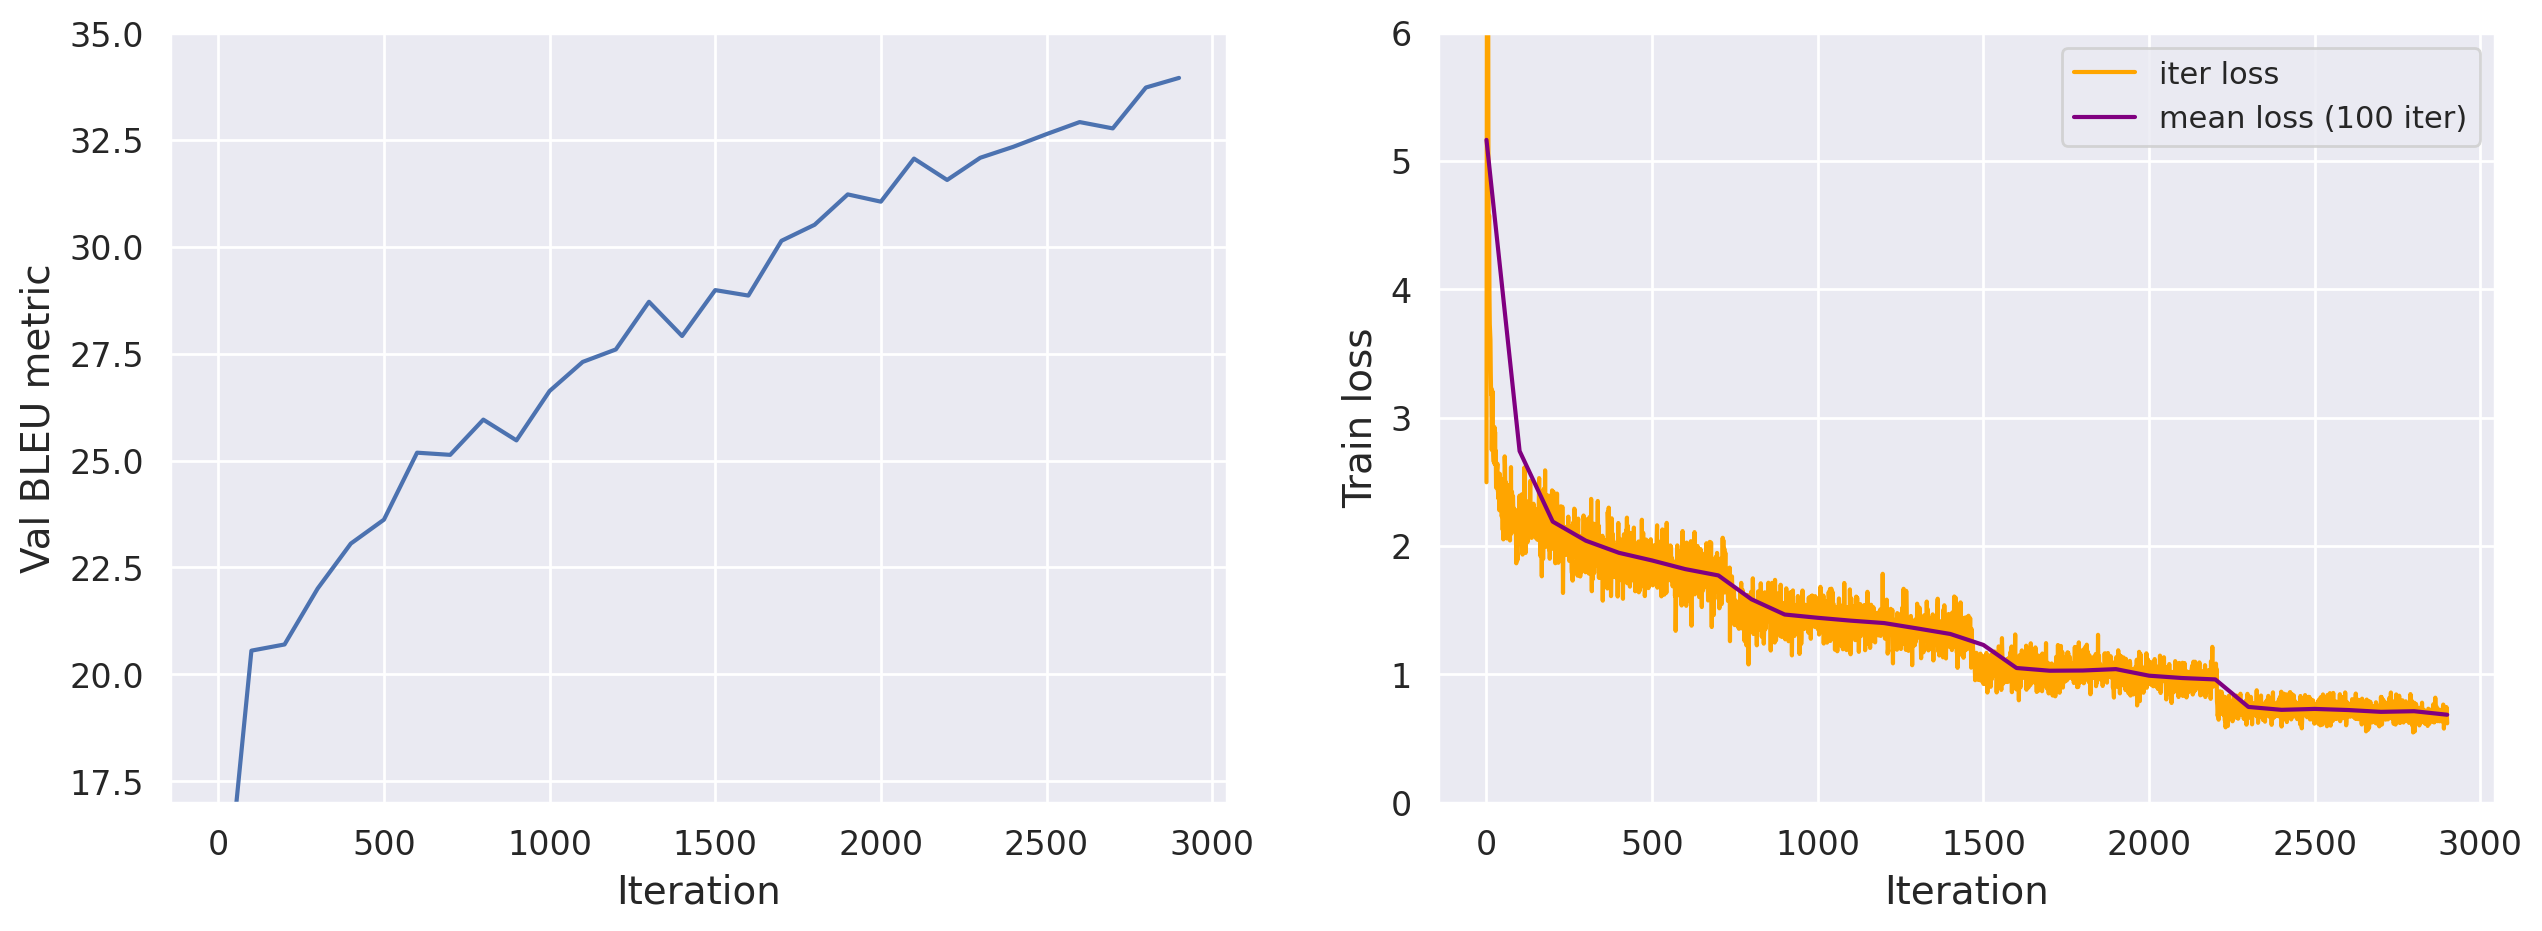

Эпоха: 3,             
Последний лосс на 100 итер.: 0.6838,             
Последнее BLEU: 33.9526


100%|█████████████████████████████████████████| 735/735 [13:13<00:00,  1.08s/it]


CPU times: user 58min 14s, sys: 1min 55s, total: 1h 9s
Wall time: 57min 53s


In [94]:
%%time

# добавим метрику перед дообучением как нулевую точку
metrics['dev_bleu'].append((0, 12.710327930484755))

iter_ = 0
mean_loss = []

for epoch in range(num_train_epochs):
    # отправляем модель в режим обучения
    model.train(True)

    for batch in tqdm(train_dataloader, ncols=80):
        batch.to(device)
        # считаем лосс, делаем бэкпроп
        # особенность модели такова, что лосс уже лежит в выходе модели
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        # записываем лосс
        metrics['train_loss'].append((iter_, loss.item()))

        # делаем шаг оптимизации и скедулера
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # в качестве отправной точки для среднего лосса возьмем средний лосс по первым 10 батчам
        if iter_ == 10:
            mean_loss.append(np.mean([i[1] for i in metrics['train_loss']]))

        if iter_ % 100 == 0 and iter_ > 0:
            # валидируемся каждые 100 итераций
            # отправляем модель в режим валидации, считаем метрику BLEU на тесте
            bleu, _, _ = compute_bleu_hf(model, eval_dataloader)
            # записываем метрику BLEU
            metrics['dev_bleu'].append((iter_, bleu))
            
            # если в этот раз BLEU самая высокая, (пере)сохраняем лучшую модель
            if bleu > best_bleu:
                best_bleu = bleu
                best_iter = iter_
                torch.save(model.state_dict(), 'marian-finetuned-hotels-ru-to-en.pt')

            # рисуем графики обучения
            clear_output(wait=True)
            plt.figure(figsize=(15, 5))

            # рисуем BLEU
            plt.subplot(1, 2, 1)
            plt.xlabel("Iteration", fontsize=14)
            plt.xticks(fontsize=12)
            plt.ylabel("Val BLEU metric", fontsize=14)
            plt.yticks(fontsize=12)
            plt.plot([p[0] for p in metrics['dev_bleu']],
                     [p[1] for p in metrics['dev_bleu']]
                     )

            if bleu > 17:
                # ограничиаем по оси Y, чтобы график был красивее
                plt.ylim(bottom=17)
            
            # считаем лосс на последних 100 итер.
            last_loss = np.mean([i[1] for i in metrics['train_loss'][-100:]])
            mean_loss.append(last_loss)

            # рисуем лосс 
            plt.subplot(1, 2, 2)
            plt.xlabel("Iteration", fontsize=14)
            plt.xticks(fontsize=12)
            plt.ylabel("Train loss", fontsize=14)
            plt.yticks(fontsize=12)
            plt.ylim(top=6)
            plt.plot(
                [p[0] for p in metrics['train_loss']],
                [p[1] for p in metrics['train_loss']],
                color="orange",
                label='iter loss')
            plt.plot(
                np.arange(0, iter_ + 1, 100),
                mean_loss,
                color="purple",
                label='mean loss (100 iter)')
            plt.legend(loc="best")

            plt.show()

            # выводим лосс на последних 100 итер., а также BLEU
            print(f'Эпоха: {epoch}, \
            \nПоследний лосс на 100 итер.: {round(last_loss, 4)}, \
            \nПоследнее BLEU: {round(bleu, 4)}', flush=True)
            model.train(True)

        iter_ += 1

    # сохраняем модель в конце каждой эпохи и пушим в репо
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch + 1}", blocking=False
        )

Думаю, что при необходимости модель хорошо училась бы и дальше.

In [95]:
print('Лучший BLEU:', best_bleu, '\nЛучшая итерация:', best_iter)

Лучший BLEU: 33.95260856203822 
Лучшая итерация: 2900


In [98]:
bleu, eval_batches_pred, eval_batches_labels = compute_bleu_hf(model, eval_dataloader)
print(f'Текущий BLEU: {round(bleu, 4)}')

assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 27, "Ты можешь больше! попробуй еще раз)"

100%|███████████████████████████████████████████| 47/47 [01:36<00:00,  2.05s/it]


Текущий BLEU: 33.8362


In [99]:
for i in range(5):
    print('ru:', split_datasets['validation'][i]['translation']['ru'])
    print('en:', eval_batches_labels[i])
    print('pred:', eval_batches_pred[i])
    print()

ru: Комплекс находится в 26 км от поселка городского типа Понти-ди-Лима и в 23 минутах езды от национального парка Пенеда-Жереш.
en: Ponte de Lima is 26 km away and the Peneda - Gerês National Park is a 23-minute drive.
pred: The property is 26 km from Ponte di Lima and 23 minutes drive from Peneda Gierês National Park.

ru: Этот отдельный коттедж находится в районе Фрайарс-Акр в старинном городке Джедборо.
en: Nestled in the historic town of Jedburgh, this self-contained annexe is within the grounds of Friars Acre.
pred: This detached cottage is located in the Freyars Akre district in the old town of Jeddah.

ru: Номера отеля Bangor Fairfield Inn располагают кондиционером, рабочим столом, принадлежностями для чая/кофе и телевизором с кабельным каналом HBO.
en: The air-conditioned rooms of Bangor Fairfield Inn are equipped with a work desk, coffee/tea making facilities, and cable TV with HBO.
pred: Air-conditioned rooms at the Bangor Fairfield Inn come with a work desk, tea/coffee maki

*Очень хорошее качество перевода.*

In [121]:
compute_bleu_from_lists(
    [
     'Burgas Airport is 22 km away.',
     'Set just 300 metres from the beach, Hakerem Luxury Suites offers modern-style accommodation fitted with air conditioning and free Wi-Fi.'
     ],
    [
     'Burgas Airport is 22 km from the property.',
     'Located just 300 metres from the beach, Hakerem Luxury Suites offers modern-style accommodation with air conditioning and free Wi-Fi access.'
     ]
)

73.58124177279737

На некоторых предложениях можно получить даже такое высокое значение BLEU.

### Скачивание и применение дообученной модели из HF. 

Поскольку мы сохранили модель в свой Hugging Face Hub, любой **может скачать себе ее и применить** локально в том же состоянии после дообучения, **запустив код ниже**.

In [100]:
from transformers import pipeline

my_model_checkpoint = "VladRub1/marian-finetuned-hotels-ru-to-en-accelerate"
my_translator = pipeline("translation", model=my_model_checkpoint)

In [101]:
# пример данных из теста:
split_datasets['validation'][10]['translation']['ru']

'Все они оснащены кондиционером и телевизором с плоским экраном, а их гости могут воспользоваться бесплатным Wi-Fi.'

In [102]:
# пример перевода данных из теста:
my_translator(
    "Все они оснащены кондиционером и телевизором с плоским экраном, а их гости могут воспользоваться бесплатным Wi-Fi."
)

[{'translation_text': 'Each room here will provide you with a flat-screen TV, air conditioning and free Wi-Fi.'}]

In [115]:
# пример данных из обучающей выборки:
split_datasets['train'][0]['translation']

{'ru': 'В числе удобств — собственная ванная комната и кухня с духовкой, микроволновой печью и холодильником.',
 'en': 'An oven, a microwave and a refrigerator can be found in the kitchen and there is a private bathroom.'}

In [113]:
# пример перевода данных из обучающей выборки:
my_translator(
    'В числе удобств — собственная ванная комната и кухня с духовкой, микроволновой печью и холодильником.'
)

[{'translation_text': 'An oven, a microwave and a fridge can be found in the kitchen and there is a private bathroom.'}]

Источники, использованные при выполнении проекта:
* https://github.com/artemxx/NMT
* https://arxiv.org/pdf/1409.0473.pdf
* https://distill.pub/2016/augmented-rnns/
* https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
* https://huggingface.co/course/chapter7/4?fw=pt